# Import Library

In [1]:
#Import Library
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Activation, Dense
from tensorflow.keras.optimizers import Adam
import keras
from tensorflow.keras.layers import Input, Dense, Layer
from keras.models import Model
from keras import backend as K
import seaborn as sns
from datetime import datetime, timedelta
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import shutil

In [2]:
# read train data and test data from directory
# dir_dataset = "E:\ilmu\Kuliah\sem 7 dan 8\Tugas Akhir\dataset\CICIDS2017\Dataset CICIDS2017"
dir_dataset = 'TRAIN DATA AND TEST DATA DIRECTORY'

df_train = pd.read_csv(dir_dataset + '\\train.csv')
df_test = pd.read_csv(dir_dataset + '\\test.csv')

In [3]:
#  load dataset into train data, train labels, test data and test labels
def load_train_test(df_train, df_test):
    train_x, train_y = df_train.iloc[:, :-1], df_train.iloc[:, -1]
    test_x, test_y = df_test.iloc[:, :-1], df_test.iloc[:, -1]
    return train_x, train_y, test_x, test_y

In [4]:
# call function load_train_test()
train_x, train_y, test_x, test_y = load_train_test(df_train, df_test)

In [6]:
# scaling train data and test data
scaler = StandardScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

# Create Model

In [7]:
# Custom layer Densetranspose for NDAE
# NDAE doesn't have decoder 
# NDAE using current layer encoder as decoder
class DenseTranspose(keras.layers.Layer):
  def __init__(self, dense, activation=None, **kwargs):
    self.dense = dense
    self.activation = keras.activations.get(activation)
    super().__init__(**kwargs)
  def get_config(self):
      config = super().get_config().copy()
      config.update({
          'dense': self.dense,
          'activation': self.activation
      })
      return config
  def build(self, batch_input_shape):
    self.biases = self.add_weight(name="bias", initializer="zeros",shape=[self.dense.input_shape[-1]])
    self.W = tf.transpose(self.dense.weights[0]) 
    super().build(batch_input_shape)
  def compute_output_shape(self, input_shape):
    return (input_shape[0], self.dense.input_shape[-1])
  def call(self, inputs):
    z = tf.matmul(inputs, self.W)
    return self.activation(z + self.biases)

In [8]:
# Custom layer sampling for model VAE
# sampling new data from distribution gaussian
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape =(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
# Define encoder and decoder for 1st Auto-Encoder Model (VAE)
latent_dim = 8
num_hidden = (train_x.shape[1], 256, 32)

#Encoder
encoder_inputs = Input(shape=(num_hidden[0],))
encoded_11 = Dense(num_hidden[1], activation='sigmoid')(encoder_inputs)
encoded_13 = Dense(num_hidden[2], activation='sigmoid')(encoded_11)

#sampling
z_mean = Dense(latent_dim, name ="z_mean")(encoded_13)
z_log_var = Dense(latent_dim, name ="z_log_var")(encoded_13)
z = Sampling()([z_mean, z_log_var])

# Decoder
latent_inputs = Input(shape=(latent_dim,))
decoded_11 = Dense(num_hidden[2], activation='sigmoid')(latent_inputs)
decoded_12 = Dense(num_hidden[1], activation='sigmoid')(decoded_11)
decoder_outputs = Dense(num_hidden[0])(decoded_12)

Encoder_1 = Model(encoder_inputs, [z_mean, z_log_var, z], name ="encoder")
Decoder_1 = Model(latent_inputs, decoder_outputs, name ="decoder")

In [10]:
# Define VAE model with encoder and decoder
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
 
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.square(data - reconstruction))
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [11]:
# construct VAE model
AE_1 = VAE(Encoder_1, Decoder_1)
AE_1.compile(optimizer ='adam')

In [12]:
# Define 2nd Auto-Encoder Model (NDAE)
num_hidden = (train_x.shape[1], 14, 28, 28)

Dense_21 = Dense(units=num_hidden[1], activation='sigmoid')
Dense_22 = Dense(units=num_hidden[2], activation='sigmoid')
Dense_23 = Dense(units=num_hidden[3], activation='sigmoid')

inputs_2 = Input(shape=(num_hidden[0],))

#Encoder
encoded_21 = Dense_21(inputs_2)
encoded_22 = Dense_22(encoded_21)
encoded_23 = Dense_23(encoded_22)

#Decoder
decoded_21 = DenseTranspose(Dense_23, activation='sigmoid')(encoded_23)
decoded_22 = DenseTranspose(Dense_22, activation='sigmoid')(decoded_21)
outputs_2 = DenseTranspose(Dense_21, activation='sigmoid')(decoded_22)

AE_2=Model(inputs_2, outputs_2, name='AE_2')
Encoder_2=Model(inputs_2, decoded_22, name='Encoder_2')

In [13]:
# compile 2nd autoencoder 
AE_2.compile(optimizer='adam', loss= 'mse')

In [14]:
Encoder_2.summary()

Model: "Encoder_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 77)]              0         
                                                                 
 dense_5 (Dense)             (None, 14)                1092      
                                                                 
 dense_6 (Dense)             (None, 28)                420       
                                                                 
 dense_7 (Dense)             (None, 28)                812       
                                                                 
 dense_transpose (DenseTrans  (None, 28)               840       
 pose)                                                           
                                                                 
 dense_transpose_1 (DenseTra  (None, 14)               434       
 nspose)                                                 

In [110]:
# construct random forest classifier
rfc = RandomForestClassifier(n_jobs=-1, n_estimators=10)

In [ ]:
# compile and train the model
AE_1.fit(train_x, train_x, epochs = 10, batch_size = 256)

In [112]:
# encode input data
AE_1_encoded_train = Decoder_1.predict(Encoder_1.predict(train_x)[2])
AE_1_encoded_test = Decoder_1.predict(Encoder_1.predict(test_x)[2])

357/357 [==============================] - 0s 1ms/step


In [102]:
# compile and train the model
AE_2.fit(AE_1_encoded_train, AE_1_encoded_train, epochs = 10, batch_size = 256)

Epoch 1/10
179/179 [==============================] - 1s 4ms/step - loss: 0.2421
Epoch 2/10
179/179 [==============================] - 1s 3ms/step - loss: 0.2023
Epoch 3/10
179/179 [==============================] - 1s 3ms/step - loss: 0.1686
Epoch 4/10
179/179 [==============================] - 1s 3ms/step - loss: 0.1405
Epoch 5/10
179/179 [==============================] - 1s 3ms/step - loss: 0.1174
Epoch 6/10
179/179 [==============================] - 1s 3ms/step - loss: 0.0986
Epoch 7/10
179/179 [==============================] - 1s 4ms/step - loss: 0.0833
Epoch 8/10
179/179 [==============================] - 1s 3ms/step - loss: 0.0707
Epoch 9/10
179/179 [==============================] - 1s 3ms/step - loss: 0.0605
Epoch 10/10
179/179 [==============================] - 1s 3ms/step - loss: 0.0521


In [103]:
# encode input data
AE_2_encoded_train = Encoder_2.predict(AE_1_encoded_train)
AE_2_encoded_test = Encoder_2.predict(AE_1_encoded_test)

357/357 [==============================] - 0s 1ms/step


In [104]:
# training random forest and evaluate accuracy
rfc.fit(AE_2_encoded_train, train_y)
rfc.score(AE_2_encoded_test, test_y)

0.5946704067321178

# Evaluation Metric
Evaluation metrics are used to assess the performance of a model. The metrics used include precision, recall, F1 score, accuracy, and ROC curve.

In [ ]:
testResult = rfc.predict(AE_2_encoded_test)

In [36]:
print(classification_report(test_y, testResult))

              precision    recall  f1-score   support

           0       0.66      0.26      0.38      4624
           1       0.64      0.91      0.75      6784

    accuracy                           0.65     11408
   macro avg       0.65      0.58      0.56     11408
weighted avg       0.65      0.65      0.60     11408



In [37]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=test_y, y_pred=testResult)

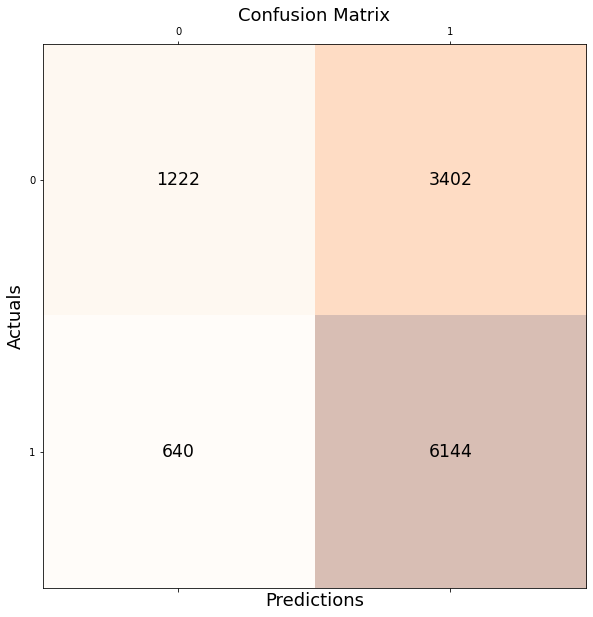

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

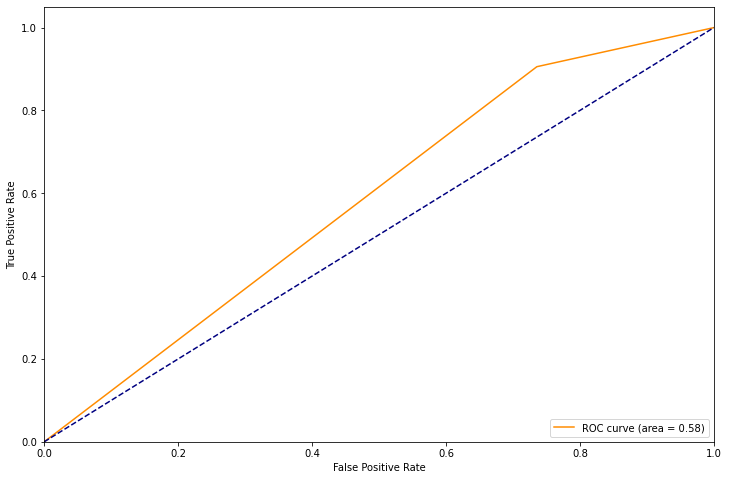

In [39]:
plt.figure(figsize = (12, 8))

fpr, tpr, _ = roc_curve(test_y, testResult)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

# 1. Hyperparameter Testing
The hyperparameters varied in this experiment are the batch size and the choice of optimizer. This testing is conducted to find the most optimal hyperparameters based on the highest accuracy. The code used is the same as before

[Adam, RMSprop]

[16, 32, 64, 128, 256]

In [50]:
def hyperparameter_testing(batch_size, opt, results):
    print('==============================')
    print('batch_size =', batch_size)
    print('optimizer =', opt)
    AE_1 = VAE(Encoder_1, Decoder_1)
    AE_1.compile(optimizer = opt)
    AE_1.fit(train_x,train_x,epochs=10,batch_size=batch_size)

    AE_1_encoded_train = Decoder_1.predict(Encoder_1.predict(train_x)[2])
    AE_1_encoded_test = Decoder_1.predict(Encoder_1.predict(test_x)[2])

    AE_2.compile(optimizer=opt, loss='mse')
    AE_2.fit(AE_1_encoded_train,AE_1_encoded_train,epochs=10,batch_size=batch_size)

    AE_2_encoded_train = Encoder_2.predict(AE_1_encoded_train)
    AE_2_encoded_test = Encoder_2.predict(AE_1_encoded_test)

    rfc = RandomForestClassifier(n_jobs=-1, n_estimators=10)
    rfc.fit(AE_2_encoded_train, train_y)
    acc = rfc.score(AE_2_encoded_test, test_y)
    results.append([acc, opt, batch_size])
    print(rfc.score(AE_2_encoded_test, test_y))
    
    print()

    testResult = rfc.predict(AE_2_encoded_test)
    print(classification_report(test_y, testResult))

In [51]:
optlist = ['rmsprop', 'adam']
batch_size_list = [16, 32, 64, 128, 256]
results = []
for opt in optlist:
    for batch_size in batch_size_list: 
        hyperparameter_testing(batch_size, opt, results)

batch_size = 16
optimizer = rmsprop
Epoch 1/10
2852/2852 [==============================] - 9s 3ms/step - loss: 0.8521 - reconstruction_loss: 0.8405 - kl_loss: 0.0117
Epoch 2/10
2852/2852 [==============================] - 8s 3ms/step - loss: 0.7740 - reconstruction_loss: 0.7342 - kl_loss: 0.0398
Epoch 3/10
2852/2852 [==============================] - 8s 3ms/step - loss: 0.7605 - reconstruction_loss: 0.7149 - kl_loss: 0.0456
Epoch 4/10
2852/2852 [==============================] - 8s 3ms/step - loss: 0.7323 - reconstruction_loss: 0.6737 - kl_loss: 0.0587
Epoch 5/10
2852/2852 [==============================] - 8s 3ms/step - loss: 0.7095 - reconstruction_loss: 0.6442 - kl_loss: 0.0653
Epoch 6/10
2852/2852 [==============================] - 8s 3ms/step - loss: 0.7006 - reconstruction_loss: 0.6340 - kl_loss: 0.0666
Epoch 7/10
2852/2852 [==============================] - 8s 3ms/step - loss: 0.6968 - reconstruction_loss: 0.6287 - kl_loss: 0.0681
Epoch 8/10
2852/2852 [=========================

2852/2852 [==============================] - 5s 2ms/step - loss: 0.4413
Epoch 7/10
2852/2852 [==============================] - 5s 2ms/step - loss: 0.4413
Epoch 8/10
2852/2852 [==============================] - 5s 2ms/step - loss: 0.4413
Epoch 9/10
2852/2852 [==============================] - 5s 2ms/step - loss: 0.4413
Epoch 10/10
357/357 [==============================] - 0s 1ms/step
0.6622545582047685

              precision    recall  f1-score   support

           0       0.83      0.21      0.34      4624
           1       0.64      0.97      0.77      6784

    accuracy                           0.66     11408
   macro avg       0.73      0.59      0.56     11408
weighted avg       0.72      0.66      0.60     11408

batch_size = 32
optimizer = adam
Epoch 1/10
1426/1426 [==============================] - 5s 3ms/step - loss: 0.4633 - reconstruction_loss: 0.3764 - kl_loss: 0.0869
Epoch 2/10
1426/1426 [==============================] - 4s 3ms/step - loss: 0.4607 - reconstruction_l

357/357 [==============================] - 2s 3ms/step - loss: 0.4862
Epoch 2/10
357/357 [==============================] - 1s 2ms/step - loss: 0.4862
Epoch 3/10
357/357 [==============================] - 1s 2ms/step - loss: 0.4862
Epoch 4/10
357/357 [==============================] - 1s 2ms/step - loss: 0.4862
Epoch 5/10
357/357 [==============================] - 1s 2ms/step - loss: 0.4862
Epoch 6/10
357/357 [==============================] - 1s 2ms/step - loss: 0.4862
Epoch 7/10
357/357 [==============================] - 1s 2ms/step - loss: 0.4862
Epoch 8/10
357/357 [==============================] - 1s 2ms/step - loss: 0.4862
Epoch 9/10
357/357 [==============================] - 1s 2ms/step - loss: 0.4862
Epoch 10/10
357/357 [==============================] - 0s 1ms/step
0.6583976157082749

              precision    recall  f1-score   support

           0       0.79      0.22      0.34      4624
           1       0.64      0.96      0.77      6784

    accuracy                   

In [52]:
maxacc = 0
chosen_hyperparameter = None
for result in results:
    acc = result[0]
    if maxacc < acc:
        maxacc = acc
        chosen_hyperparameter = result.copy()

## Result of Hyperparameter Testing

In [54]:
for r in results:
    print(f'accuracy: {r[0]} - optimizer: {r[1]} - batch size: {r[2]}')

accuracy: 0.6623422159887798 - optimizer: rmsprop - batch size: 16
accuracy: 0.6631311360448808 - optimizer: rmsprop - batch size: 32
accuracy: 0.6597124824684432 - optimizer: rmsprop - batch size: 64
accuracy: 0.6657608695652174 - optimizer: rmsprop - batch size: 128
accuracy: 0.6661115007012622 - optimizer: rmsprop - batch size: 256
accuracy: 0.6622545582047685 - optimizer: adam - batch size: 16
accuracy: 0.6651472650771388 - optimizer: adam - batch size: 32
accuracy: 0.6608520336605891 - optimizer: adam - batch size: 64
accuracy: 0.6583976157082749 - optimizer: adam - batch size: 128
accuracy: 0.6526122019635343 - optimizer: adam - batch size: 256


# 2. Model Validation Testing
Testing is performed using K-Fold validation with the most optimal hyperparameters. The results of this testing include the precision, recall, accuracy, F1-score, ROC curve, and the training time for each iteration of the model.

In [55]:
def convergence_time_test(epochs, opt, batch_size, roc_list, time_list, acc_list ):
    print('==============================')
    print('optimizer =', opt)
    print('batch size =', batch_size)
    print('KFold = 10')
    kfold = KFold(n_splits=10, shuffle=True)
    total_time1 = 0
    total_time2 = 0
    total_acc = 0
    i = 1
    
    train_x, train_y, _, _ = load_train_test(df_train, df_test)
    for train_idx, valid_idx in kfold.split(train_x):
        AE_1 = VAE(Encoder_1, Decoder_1)
        AE_1.compile(optimizer=opt)
        AE_2.compile(optimizer=opt, loss= 'mse')
        print('\nCurrent KFold = ', i)
        Xtrain, Xvalid = train_x.iloc[train_idx], train_x.iloc[valid_idx]
        Ytrain, Yvalid = train_y.iloc[train_idx], train_y.iloc[valid_idx]
        
        scaler_kfold = StandardScaler()
        scaler_kfold.fit(Xtrain)
        Xtrain_scaled = scaler_kfold.transform(Xtrain)
        Xvalid_scaled = scaler_kfold.transform(Xvalid)
    
        time_before_training_AE_1 = datetime.now()
        AE_1.fit(Xtrain_scaled, Xtrain_scaled, epochs=epochs, batch_size=batch_size)
        time_after_training_AE_1 = datetime.now()
        delta_time_AE_1 = time_after_training_AE_1 - time_before_training_AE_1
        
        AE_1_encoded_train = Decoder_1.predict(Encoder_1.predict(Xtrain_scaled)[2])
        AE_1_encoded_valid = Decoder_1.predict(Encoder_1.predict(Xvalid_scaled)[2])

        time_before_training_AE_2 = datetime.now()
        AE_2.fit(AE_1_encoded_train, AE_1_encoded_train, epochs=epochs, batch_size=batch_size)
        time_after_training_AE_2 = datetime.now()
        delta_time_AE_2 = time_after_training_AE_2 - time_before_training_AE_2
        
        AE_2_encoded_train = Encoder_2.predict(AE_1_encoded_train)
        AE_2_encoded_valid = Encoder_2.predict(AE_1_encoded_valid)

        rfc.fit(AE_2_encoded_train, Ytrain)
            
        print(time_before_training_AE_1)
        print(time_after_training_AE_1)
        print('time taken for training 1st autoencoder', delta_time_AE_1.total_seconds())
        print()
        print(time_before_training_AE_2)
        print(time_after_training_AE_2)
        print('time taken for training 2nd autoencoder', delta_time_AE_2.total_seconds())
        print()
        print('total time =', delta_time_AE_1.total_seconds() + delta_time_AE_2.total_seconds())

        total_time1 += delta_time_AE_1.total_seconds()
        total_time2 += delta_time_AE_2.total_seconds()
        time_list.append([delta_time_AE_1.total_seconds(), delta_time_AE_2.total_seconds()])
        
        print('Data Train')
        trainResult = rfc.predict(AE_2_encoded_train)
        print(rfc.score(AE_2_encoded_train, Ytrain))
        print(classification_report(Ytrain, trainResult))
        
        print('Data Valid')
        validResult = rfc.predict(AE_2_encoded_valid)
        valid_acc = rfc.score(AE_2_encoded_valid, Yvalid)
        total_acc += valid_acc
        acc_list.append(valid_acc)
        print(valid_acc)
        print(classification_report(Yvalid, validResult))
        
        print()
              
        fpr, tpr, _ = roc_curve(Yvalid, validResult)
        roc_auc = auc(fpr, tpr)
        roc_list.append([fpr, tpr, roc_auc])
        print()
        i+=1
        
    avg_time_AE_1 = total_time1 / 10 
    avg_time_AE_2 = total_time2 / 10
    avg_total_val_acc = total_acc / 10
    print('Average training time for AE_1:', avg_time_AE_1, 'seconds')
    print('Average training time for AE_2:', avg_time_AE_2, 'seconds')
    print('Average accuracy of 10 folds :', avg_total_val_acc)

In [56]:
epochs = 10
opt = chosen_hyperparameter[1]
batch_size = chosen_hyperparameter[2]
roc_list = []
time_list = []
acc_list = []
convergence_time_test(epochs, opt, batch_size, roc_list, time_list, acc_list)

optimizer = rmsprop
batch size = 256
KFold = 10

Current KFold =  1
Epoch 1/10
161/161 [==============================] - 2s 6ms/step - loss: 0.3915 - reconstruction_loss: 0.3047 - kl_loss: 0.0869
Epoch 2/10
161/161 [==============================] - 1s 6ms/step - loss: 0.4383 - reconstruction_loss: 0.3516 - kl_loss: 0.0867
Epoch 3/10
161/161 [==============================] - 1s 5ms/step - loss: 0.3926 - reconstruction_loss: 0.3053 - kl_loss: 0.0872
Epoch 4/10
161/161 [==============================] - 1s 6ms/step - loss: 0.3910 - reconstruction_loss: 0.3034 - kl_loss: 0.0877
Epoch 5/10
161/161 [==============================] - 1s 5ms/step - loss: 0.3899 - reconstruction_loss: 0.3031 - kl_loss: 0.0868
Epoch 6/10
161/161 [==============================] - 1s 5ms/step - loss: 0.3909 - reconstruction_loss: 0.3035 - kl_loss: 0.0874
Epoch 7/10
161/161 [==============================] - 1s 5ms/step - loss: 0.3883 - reconstruction_loss: 0.3001 - kl_loss: 0.0882
Epoch 8/10
161/161 [=========

Epoch 1/10
161/161 [==============================] - 2s 5ms/step - loss: 0.3975 - reconstruction_loss: 0.3109 - kl_loss: 0.0865
Epoch 2/10
161/161 [==============================] - 1s 6ms/step - loss: 0.3855 - reconstruction_loss: 0.2992 - kl_loss: 0.0863
Epoch 3/10
161/161 [==============================] - 1s 5ms/step - loss: 0.3874 - reconstruction_loss: 0.3007 - kl_loss: 0.0867
Epoch 4/10
161/161 [==============================] - 1s 5ms/step - loss: 0.3838 - reconstruction_loss: 0.2977 - kl_loss: 0.0861
Epoch 5/10
161/161 [==============================] - 1s 5ms/step - loss: 0.3887 - reconstruction_loss: 0.3014 - kl_loss: 0.0872
Epoch 6/10
161/161 [==============================] - 1s 6ms/step - loss: 0.3841 - reconstruction_loss: 0.2976 - kl_loss: 0.0865
Epoch 7/10
161/161 [==============================] - 1s 6ms/step - loss: 0.3844 - reconstruction_loss: 0.2983 - kl_loss: 0.0861
Epoch 8/10
161/161 [==============================] - 1s 5ms/step - loss: 0.3833 - reconstruction

## Result of Validation Model

In [57]:
for i,acc in enumerate(acc_list):
    print(f'fold {i+1} - accuracy: {acc} - time AE1: {time_list[i][0]} - time AE2: {time_list[i][1]}')

fold 1 - accuracy: 0.6594345825115056 - time AE1: 9.889002 - time AE2: 5.254999
fold 2 - accuracy: 0.6579005040543502 - time AE1: 9.723982 - time AE2: 5.365184
fold 3 - accuracy: 0.6574621959237343 - time AE1: 9.926389 - time AE2: 5.599991
fold 4 - accuracy: 0.6690773613850537 - time AE1: 10.328003 - time AE2: 5.767001
fold 5 - accuracy: 0.6719263642340565 - time AE1: 10.057708 - time AE2: 5.78024
fold 6 - accuracy: 0.6526408064869603 - time AE1: 10.250323 - time AE2: 5.845001
fold 7 - accuracy: 0.6703922857769011 - time AE1: 11.220577 - time AE2: 6.540983
fold 8 - accuracy: 0.6688582073197458 - time AE1: 11.512 - time AE2: 7.74461
fold 9 - accuracy: 0.6615519508987286 - time AE1: 11.056002 - time AE2: 7.510924
fold 10 - accuracy: 0.6635247698377904 - time AE1: 11.454826 - time AE2: 6.20566


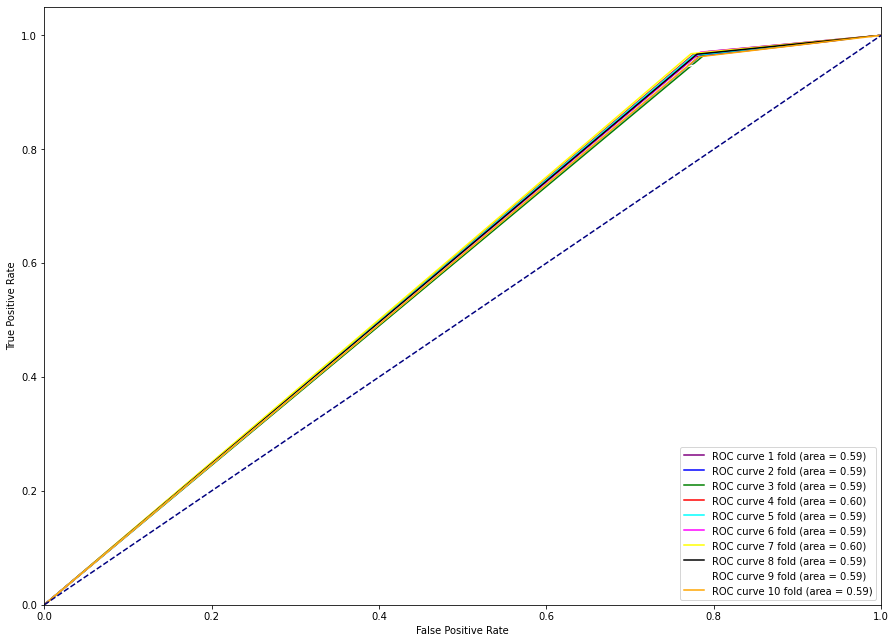

In [58]:
plt.figure(figsize = (15, 11))
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white', 'orange', 'purple']

for i in range(10):        
    plt.plot(roc_list[i][0], roc_list[i][1], color=colors[i-1], label=f'ROC curve {i+1} fold (area = %0.2f)' % roc_list[i][2])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [59]:
for i,el in enumerate(roc_list):
    print('ROC Curve', i+1,'fold',el[2])

ROC Curve 1 fold 0.5923429659969887
ROC Curve 2 fold 0.5901798896781505
ROC Curve 3 fold 0.5889979298860545
ROC Curve 4 fold 0.5954408231519897
ROC Curve 5 fold 0.5946031589794685
ROC Curve 6 fold 0.5931933241949077
ROC Curve 7 fold 0.5974258033671305
ROC Curve 8 fold 0.5935106110692541
ROC Curve 9 fold 0.5886754496014184
ROC Curve 10 fold 0.5900992928451997
